<a href="https://colab.research.google.com/github/sangse/Stock_EDA/blob/main/NewStockData_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
def df_slicing_window_3(df):
  total_length = len(df)
  data_array = []
  for window_size in range(4, 13):
      numofblock = math.ceil((total_length - window_size) / 1) + 1
      for num in range(numofblock):
          start_index = num
          end_index = start_index + window_size
          if end_index > total_length:
              break
          data = df.iloc[start_index:end_index].values
          data = np.pad(data, ((0, 12 - len(data)), (0, 0)), mode='constant')
          data_array.append(data)
  return (data_array)

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 디렉토리 설정
directory = '/content/drive/MyDrive/data/신규상장데이터'

# 디렉토리 안의 파일 이름들을 리스트로 가져옴
file_names = os.listdir(directory)

# MinMaxScaler 초기화
min_max_scaler = MinMaxScaler()

# 결과를 저장할 리스트 초기화
processed_data = []

for name in file_names:
    # 파일 데이터프레임으로 저장하고 일자를 인덱스로 설정하고 오름차순으로 정렬
    tmp = pd.read_csv(os.path.join(directory, name), encoding='cp949')

    # 일자를 datetime 형식으로 변환하고 정렬
    tmp = tmp.sort_values(by='일자', ascending=True)
    tmp.set_index('일자', inplace=True)

    # 공모가가 없는 데이터 건너뛰기
    if '공모가' not in tmp.columns or tmp['공모가'].isnull().any():
        continue

    # 공모가 대비 가격 특징 추가
    tmp['공모가대비현재가'] = tmp['현재가'] / tmp['공모가']
    tmp['공모가대비저가'] = tmp['저가'] / tmp['공모가']
    tmp['공모가대비고가'] = tmp['고가'] / tmp['공모가']
    tmp['공모가대비시가'] = tmp['시가'] / tmp['공모가']

    # MinMaxScaler 적용
    tmp['현재가'] = min_max_scaler.fit_transform(tmp[['현재가']])
    tmp['저가'] = min_max_scaler.fit_transform(tmp[['저가']])
    tmp['고가'] = min_max_scaler.fit_transform(tmp[['고가']])
    tmp['시가'] = min_max_scaler.fit_transform(tmp[['시가']])
    tmp['거래량'] = min_max_scaler.fit_transform(tmp[['거래량']])
    tmp['거래대금'] = min_max_scaler.fit_transform(tmp[['거래대금']])

    # 조건 검사: 공모가 대비 현재가가 5를 초과하는지 확인
    if any(tmp['공모가대비현재가'] > 5):
        print(f"{name}: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.")

    # 공모가대비현재가를 제일 첫번째 인덱스로 설정
    col = tmp.pop('공모가대비현재가')
    tmp.insert(0, '공모가대비현재가', col)

    # 필요없는 특징들 제거
    drop_list = ['종목코드', 'Unnamed: 0', '종목명', '시장구분', '공모가']
    tmp.drop(columns=drop_list, inplace=True)

    # NaN 값이 하나라도 있으면 건너뛰기
    if tmp.isna().any().any():
        continue

    # 처리된 데이터프레임을 리스트에 추가
    processed_data.append(tmp)

# processed_data 리스트에 저장된 데이터프레임들을 순차적으로 사용할 수 있습니다.
# 필요에 따라 하나의 데이터프레임으로 결합할 수도 있습니다.
result_df = pd.concat(processed_data)


명신산업.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
자이언트스텝.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
맥스트.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
미래반도체.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
꿈비.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
LS머트리얼즈.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
큐리옥스바이오시스템즈.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
에코프로머티.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.
우진엔텍.csv: 공모가 대비 현재가가 5를 초과하는 데이터가 존재합니다.


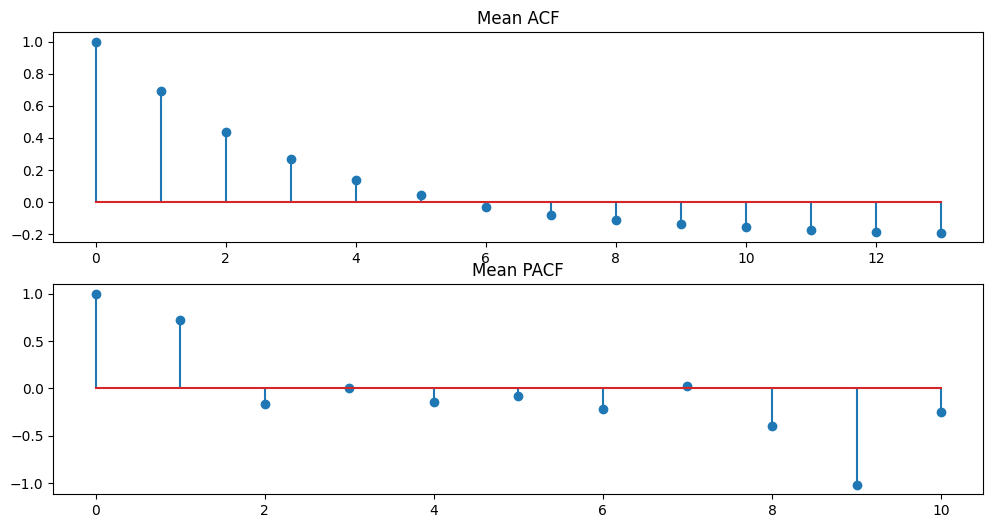

In [ ]:
import numpy as np
import statsmodels.api as sm
import numpy as np

# 모든 파일의 데이터 길이 중 최대 길이를 찾습니다.
max_length = min(len(tmp) for tmp in processed_data)

# 각 파일의 데이터를 패딩하여 최대 길이에 맞춥니다.
padded_data = []
for tmp in processed_data:
    # padding_length = max_length - len(tmp)
    # padded_tmp = np.pad(tmp, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)

    padded_data.append(tmp[:max_length])

# 패딩된 데이터로 ACF 및 PACF 값을 계산합니다.
acf_values = []
pacf_values = []

for tmp in padded_data:
    acf_result = sm.tsa.acf(tmp.iloc[:, 0])  # '공모가대비현재가' 열에 대한 ACF 계산
    pacf_result = sm.tsa.pacf(tmp.iloc[:, 0])  # '공모가대비현재가' 열에 대한 PACF 계산
    acf_values.append(acf_result)
    pacf_values.append(pacf_result)

# ACF 및 PACF 값의 평균을 계산합니다.
mean_acf = np.mean(acf_values, axis=0)
mean_pacf = np.mean(pacf_values, axis=0)

# 평균 ACF 및 PACF 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(mean_acf)
plt.title('Mean ACF')

plt.subplot(2, 1, 2)
plt.stem(mean_pacf)
plt.title('Mean PACF')

plt.show()